#### Import libraries

In [1]:
from scipy.interpolate import interp1d
from scipy import integrate
import scipy.stats as ss
import time     
from scipy.stats import norm
import pandas as pd
import numpy as np
import datetime as dt
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sys import argv


#### Created the df and performed some data cleaning

In [2]:
df = pd.read_csv('SPX_2016_options.csv')

In [3]:
SPX_2016_options=df.iloc[:,np.r_[2:9,11:13,16]]
SPX_2016_options.columns=['t','T','Maturity','Option','Strike Price','Bid price','Ask price','BS IV','Stock Price','interest rate']
SPX_2016_options=SPX_2016_options.dropna()

In [4]:
SPX_2016_options.insert(5,'Option Price',SPX_2016_options[['Bid price','Ask price']].mean(axis=1))
SPX_2016_options.drop(SPX_2016_options[SPX_2016_options['Option Price'] <= 0.05].index , inplace=True)

0.075

#### Obtained OTM options

In [5]:
OTM_options = SPX_2016_options[(SPX_2016_options['Option'] == 1) & (SPX_2016_options['Stock Price'].values < SPX_2016_options['Strike Price']) | 
                                   (SPX_2016_options['Option'] == -1) & (SPX_2016_options['Stock Price'].values > SPX_2016_options['Strike Price'])]
OTM_options['t']=OTM_options['t'].apply(dt.datetime.fromordinal).dt.strftime('%d-%m-%Y')
OTM_options['T']=OTM_options['T'].apply(dt.datetime.fromordinal).dt.strftime('%d-%m-%Y')
OTM_options

<ipython-input-5-84862f16e652>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OTM_options['t']=OTM_options['t'].apply(dt.datetime.fromordinal).dt.strftime('%d-%m-%Y')
<ipython-input-5-84862f16e652>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  OTM_options['T']=OTM_options['T'].apply(dt.datetime.fromordinal).dt.strftime('%d-%m-%Y')


t           T  Maturity  Option  Strike Price  Option Price  \
155     04-01-2017  15-01-2017        11       1          2015        24.450   
156     04-01-2017  15-01-2017        11       1          2020        21.500   
157     04-01-2017  15-01-2017        11       1          2025        19.050   
158     04-01-2017  15-01-2017        11       1          2030        16.800   
159     04-01-2017  15-01-2017        11       1          2035        14.700   
...            ...         ...       ...     ...           ...           ...   
619806  30-04-2017  01-04-2018       336      -1           750         1.575   
619807  30-04-2017  01-04-2018       336      -1           800         1.925   
619808  30-04-2017  01-04-2018       336      -1           850         2.400   
619809  30-04-2017  01-04-2018       336      -1           900         2.975   
619810  30-04-2017  01-04-2018       336      -1           950         3.650   

        Bid price  Ask price     BS IV  Stock Price  interest rate  
155         23.40      25.50  0.195975      2012.66       0.007121  
156         20.60      22.40  0.190988      2012.66       0.007121  
157         18.10      20.00  0.188562      2012.66       0.007121  
158         15.90      17.70  0.186419      2012.66       0.007121  
159         13.80      15.60  0.184163      2012.66       0.007121  
...           ...        ...       ...          ...            ...  
619806       1.25       1.90  0.442646      2065.30       0.007088  
619807       1.60       2.25  0.426590      2065.30       0.007088  
619808       2.10       2.70  0.412802      2065.30       0.007088  
619809       2.65       3.30  0.399738      2065.30       0.007088  
619810       3.30       4.00  0.387017      2065.30       0.007088  

[272078 rows x 11 columns]

#### Defined some functions (BS pricing, IV interpolation)

In [6]:
def BlackScholes(CallPutFlag,S,X,v,r,T):
    d1 = (np.log(S/X)+(r+v*v/2.)*T)/(v*np.sqrt(T))
    d2 = d1-v*np.sqrt(T)
    if CallPutFlag=='C':
        P = S*norm.cdf(d1) - X*np.exp(-r*T)*norm.cdf(d2)
    else:
        P = -S*norm.cdf(-d1) + X*np.exp(-r*T)*norm.cdf(-d2)
    return P

In [7]:
def ivol(K,IV,Kall):
    if Kall>=K[len(K)-1]:
        Kall=K[len(K)-1]
    if Kall<=K[0]:
        Kall=K[0]
    funy = interp1d(K,IV, kind='cubic', fill_value="extrapolate")
    y = funy(Kall)
    if (np.sum(y<0)>0):
        if Kall>=K[len(K)-1]:
            Kall=K[len(K)-1]
        if Kall<=K[0]:
            Kall=K[0]
        funy = interp1d(K,IV, kind='linear', fill_value="extrapolate")
        y=funy(Kall)
    return(y)

In [8]:
def RiskNeutralVolatilitySkewKurt_JVKR(Kvector, IVvector, S0, T, r):
    kmin=.1*S0
    kmax=3.5*S0
    
    def V1(K):
        V1=2*(1-np.log(K/S0))*BlackScholes('C',S0, K, ivol(Kvector,IVvector,K), r, T)/np.power(K,2)        
        return(V1)
    
    def V2(K):
        V2=2*(1+np.log(S0/K))*BlackScholes('P',S0, K, ivol(Kvector,IVvector,K), r, T)/np.power(K,2)       
        return(V2)
    
    def W1(K):
        W1=(6*np.log(K/S0)-3*np.power(np.log(K/S0),2))*BlackScholes('C',S0, K, ivol(Kvector,IVvector,K), r, T)/np.power(K,2)
        return(W1) 
    
    def W2(K):
        W2=(6*np.log(S0/K)+3*np.power(np.log(S0/K),2))*BlackScholes("P",S0, K, ivol(Kvector,IVvector,K), r, T)/np.power(K,2)
        return(W2) 
       
    def X1(K):
        X1=(((12*np.power(np.log(K/S0),2) - 4*np.power(np.log(K/S0),3)))*(BlackScholes('C',S0, K, ivol(Kvector,IVvector,K), r, T))/np.power(K,2))
        return(X1) 
        
    def X2(K):
        X2=(((12*np.power(np.log(S0/K),2) + 4*np.power(np.log(S0/K),3)))*(BlackScholes("P",S0, K, ivol(Kvector,IVvector,K), r, T))/np.power(K,2))
        return(X2) 
    
    V=integrate.quad(V1,S0,kmax)[0]+integrate.quad(V2,kmin,S0)[0]
    W=integrate.quad(W1,S0,kmax)[0]-integrate.quad(W2,kmin,S0)[0]
    X=integrate.quad(X1,S0,kmax)[0]+integrate.quad(X2,kmin,S0)[0]
    mu=np.exp(r*T)-1-np.exp(r*T)*V/2-np.exp(r*T)*W/6-np.exp(r*T)*X/24

    vol=np.sqrt(1/T * V)
    skew=( np.exp(r*T)*W - 3*mu*np.exp(r*T)*V + 2*np.power(mu,3)) / np.power(np.exp(r*T)*V - np.power(mu,2),3/2),
    kurt=( np.exp(r*T)*X - 4*mu*np.exp(r*T)*W + 6*np.exp(r*T)*np.power(mu,2)*V - 3*np.power(mu,4)) / np.power(np.exp(r*T)*V - np.power(mu,2),2)
    
    return vol

#### Plotted the volatility surface for each day

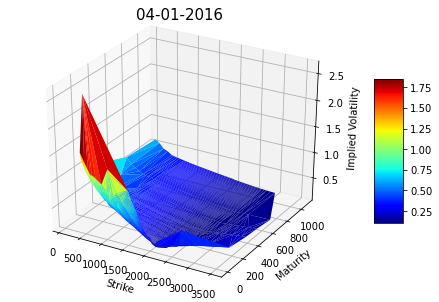

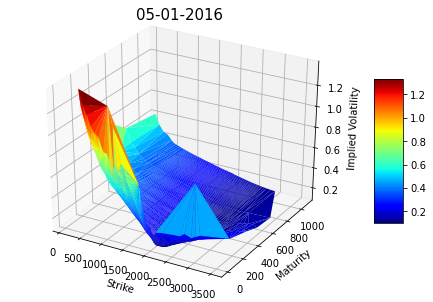

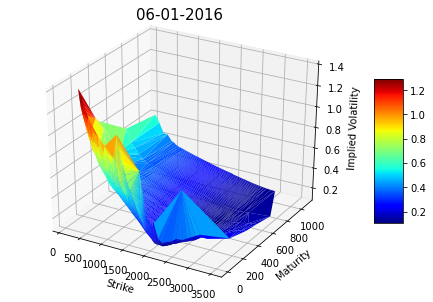

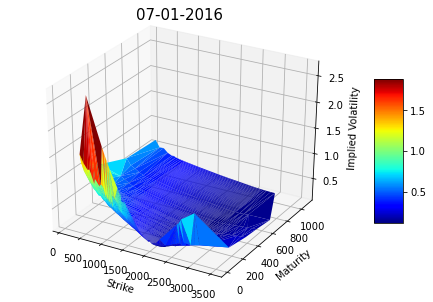

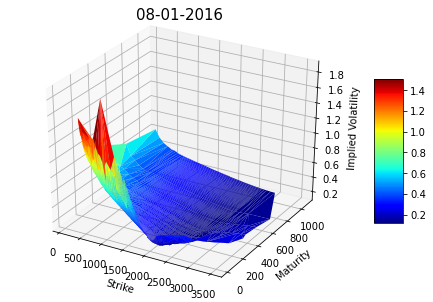

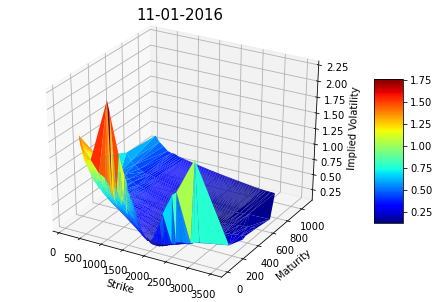

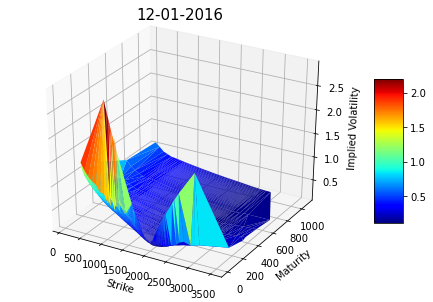

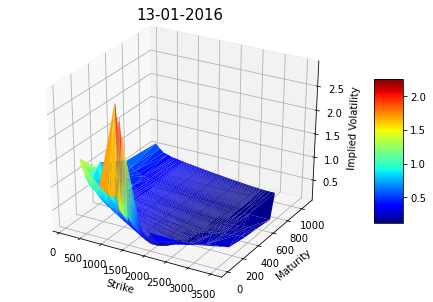

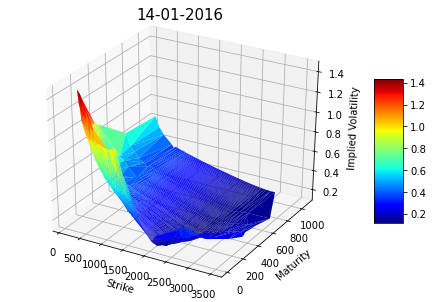

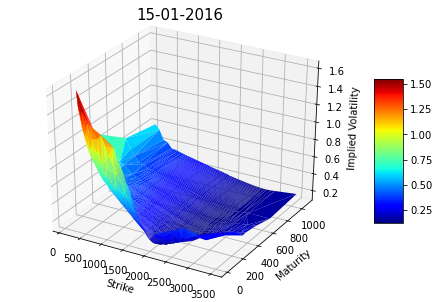

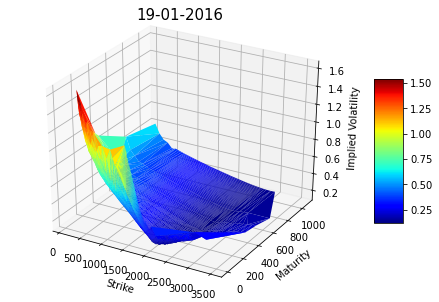

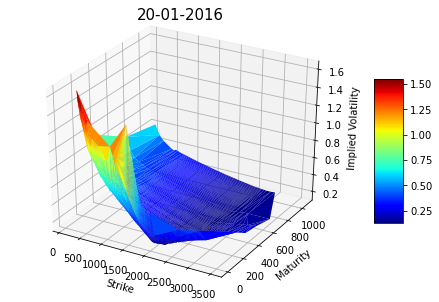

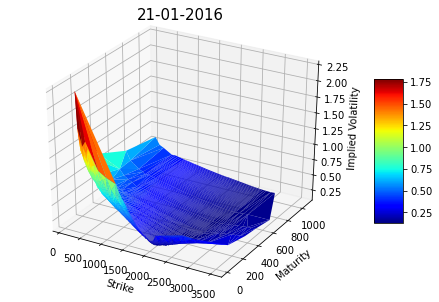

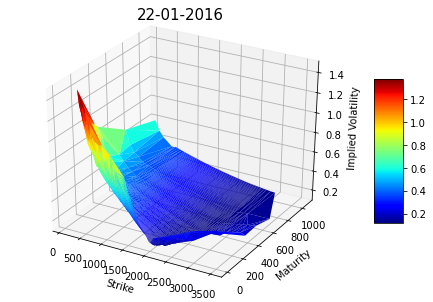

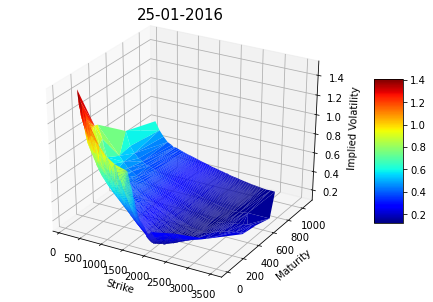

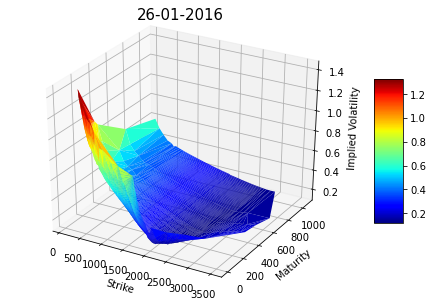

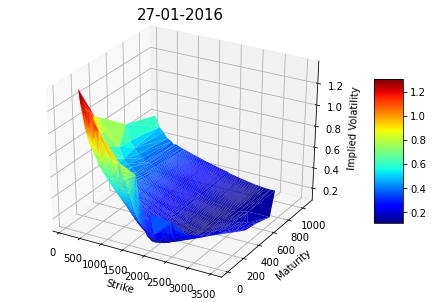

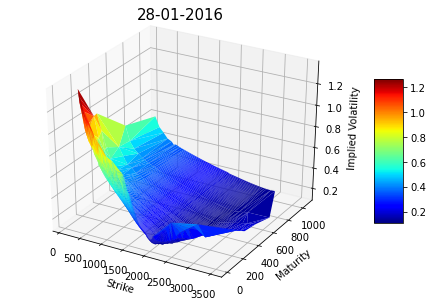

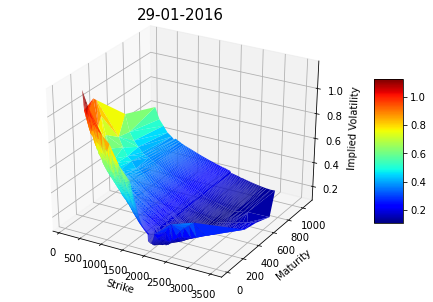

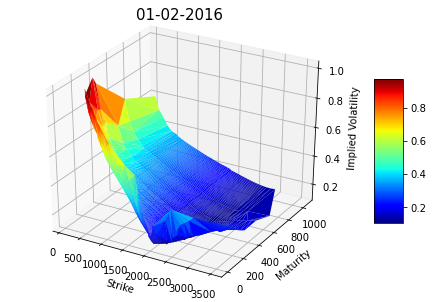

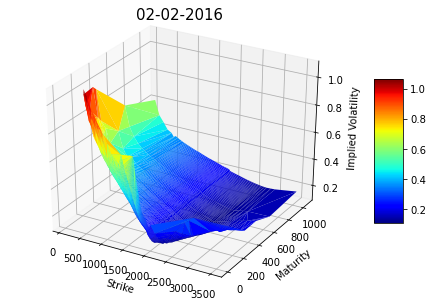

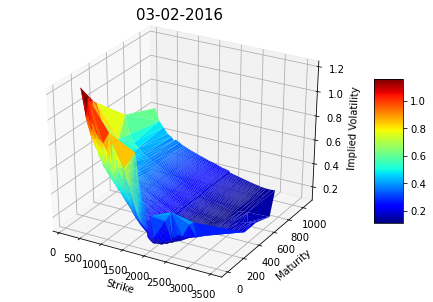

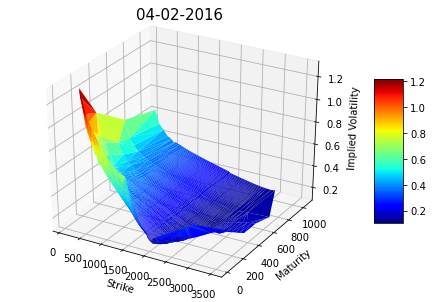

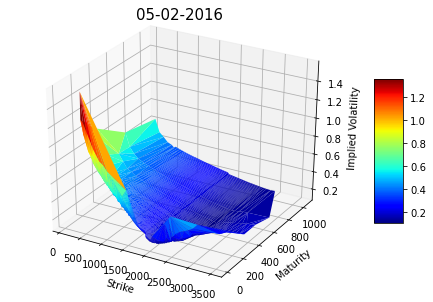

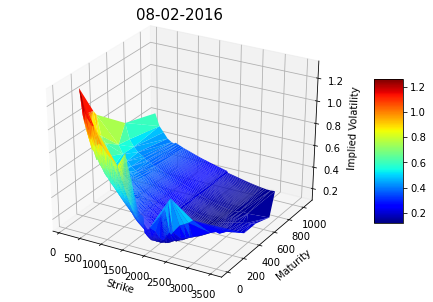

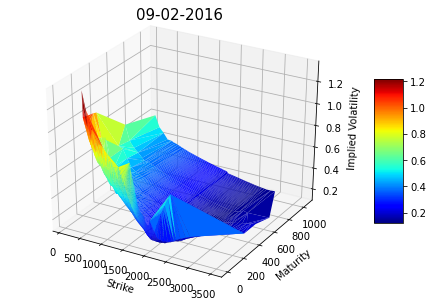

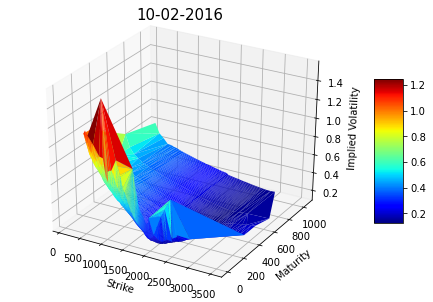

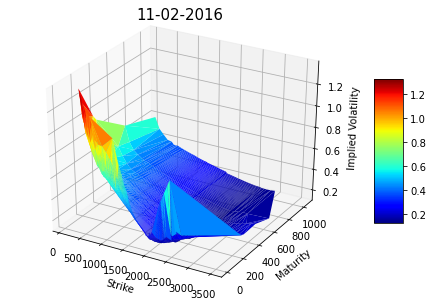

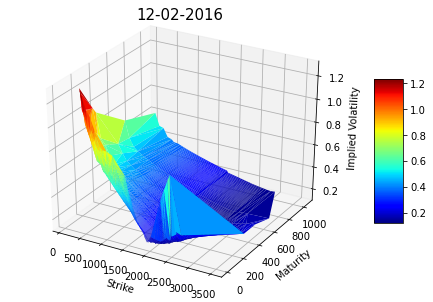

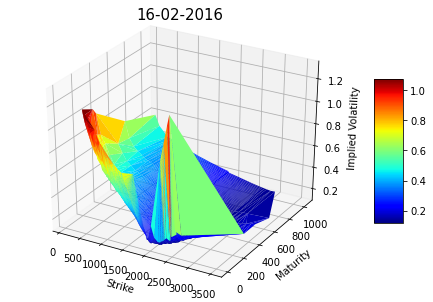

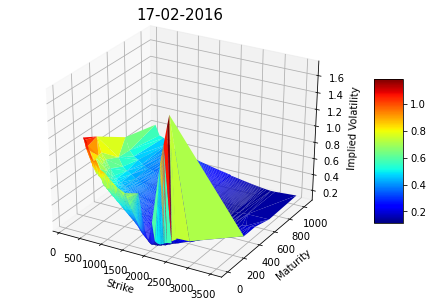

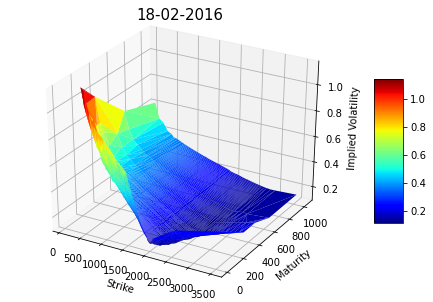

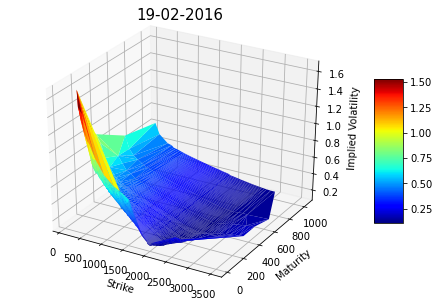

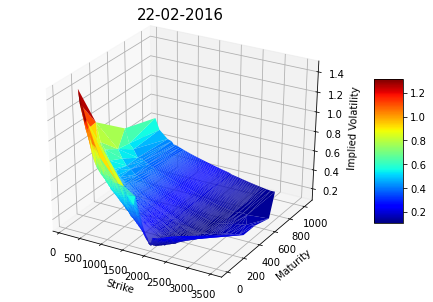

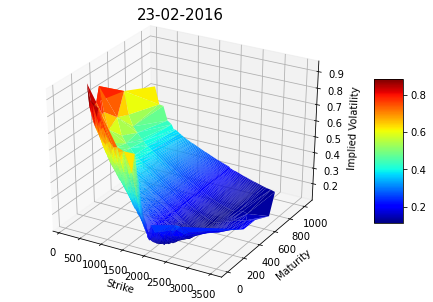

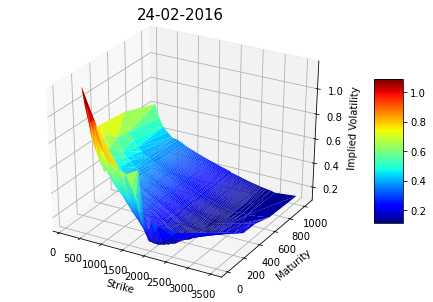

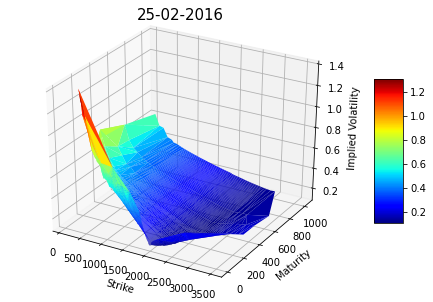

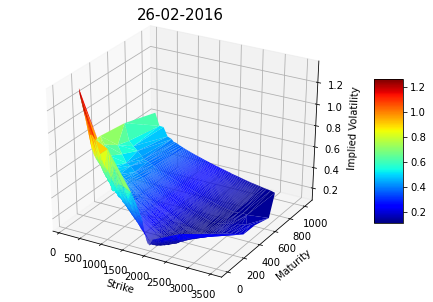

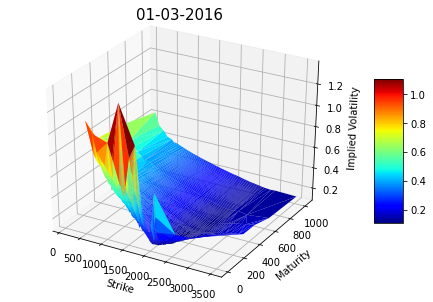

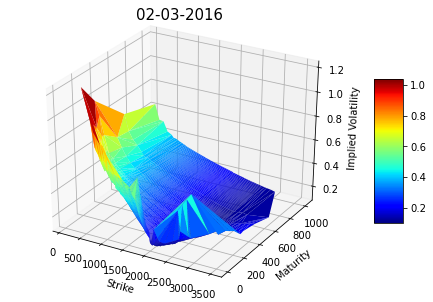

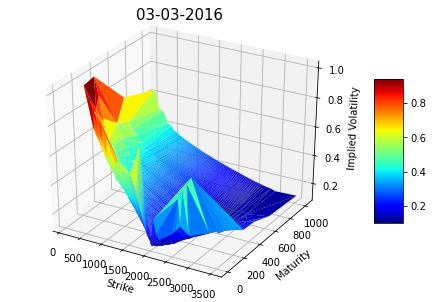

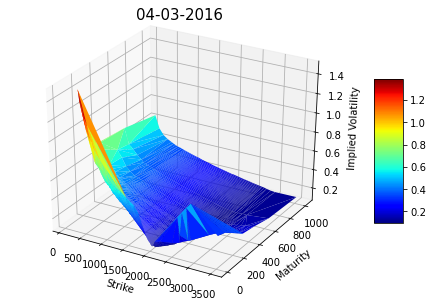

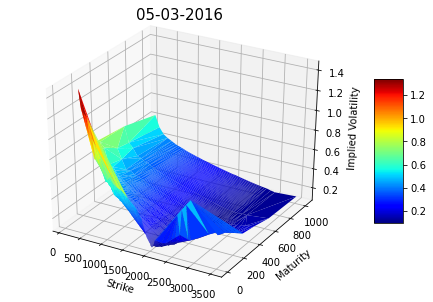

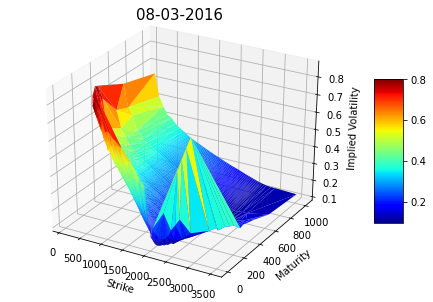

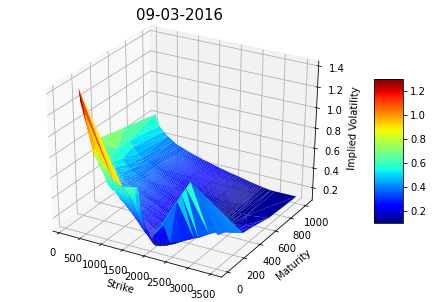

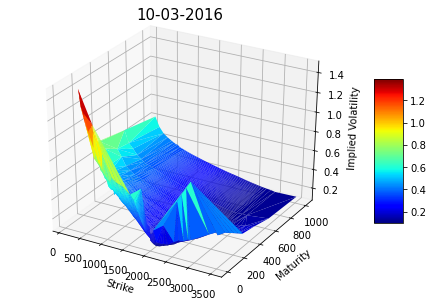

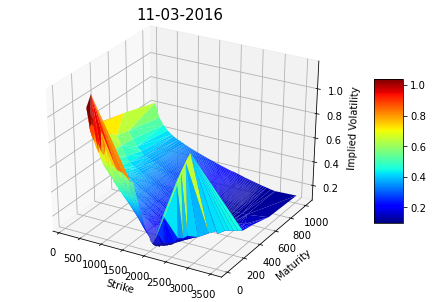

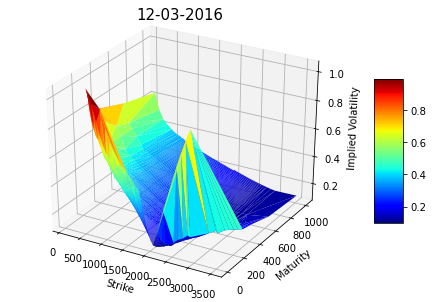

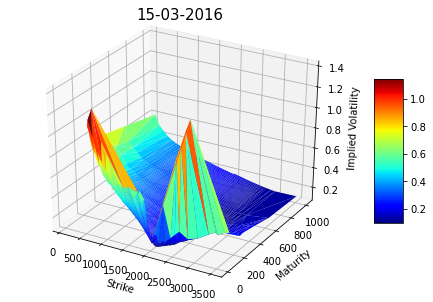

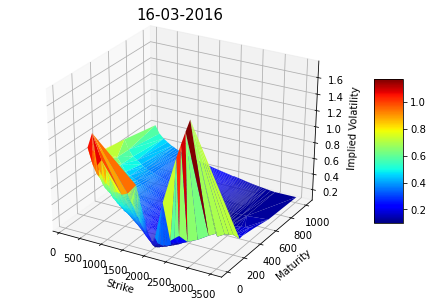

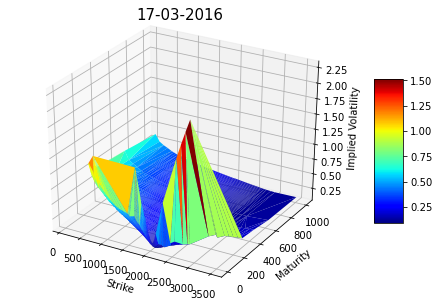

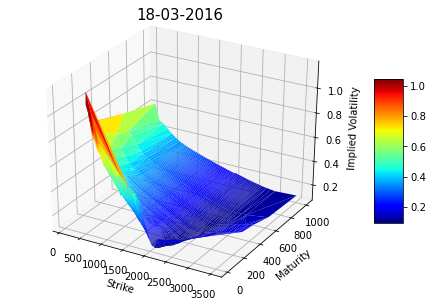

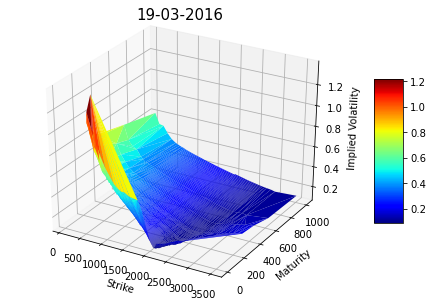

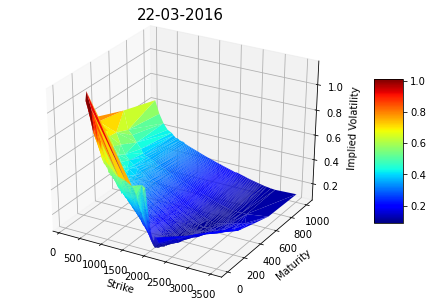

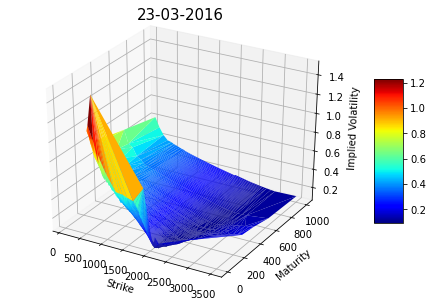

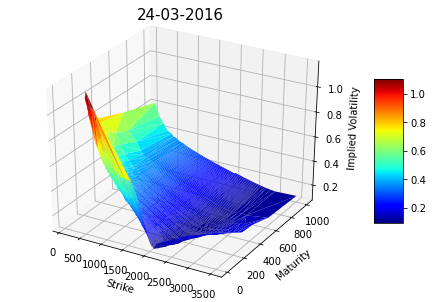

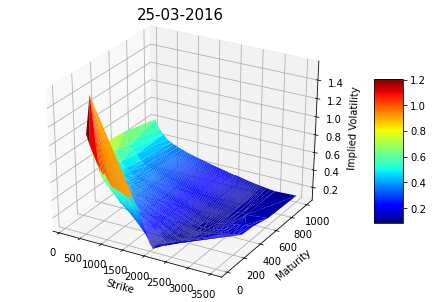

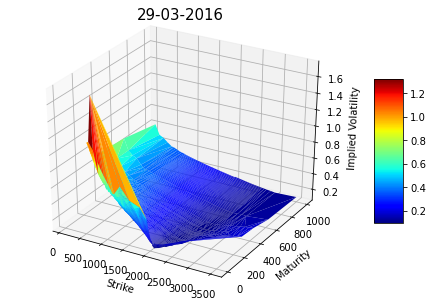

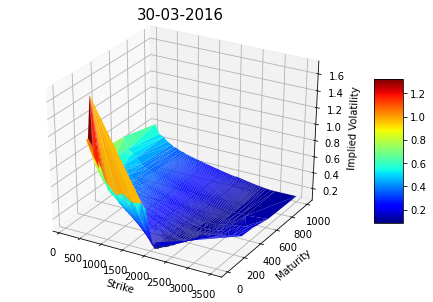

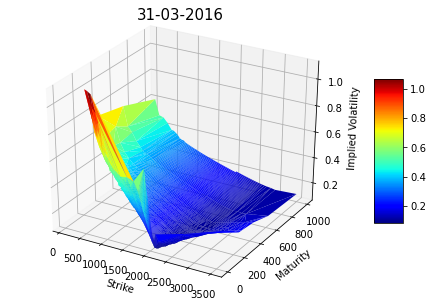

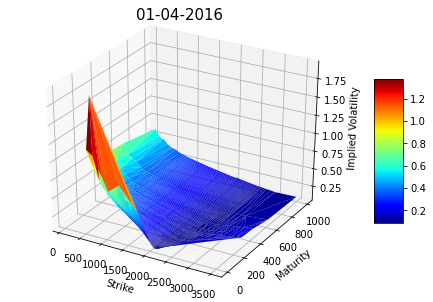

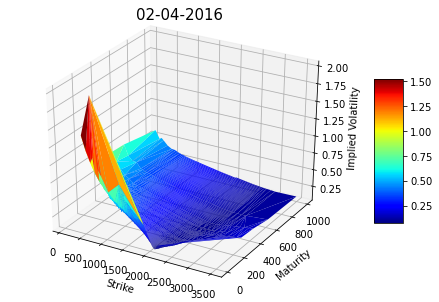

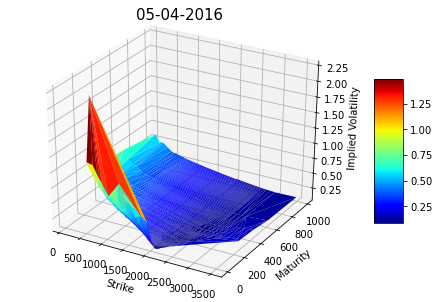

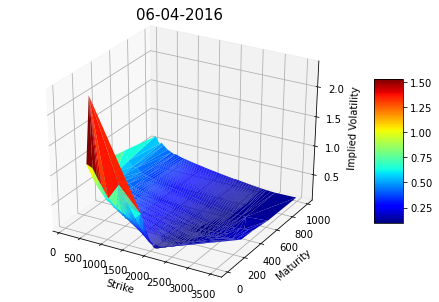

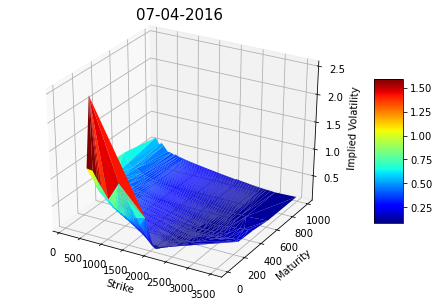

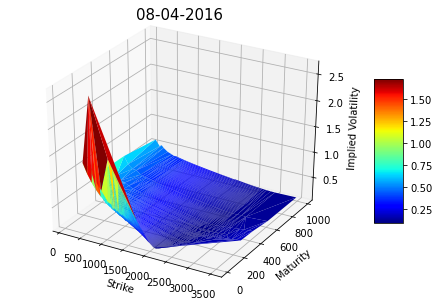

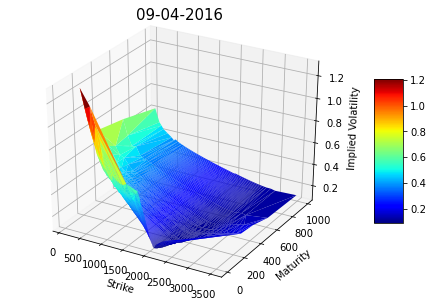

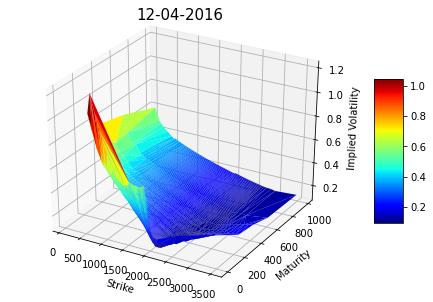

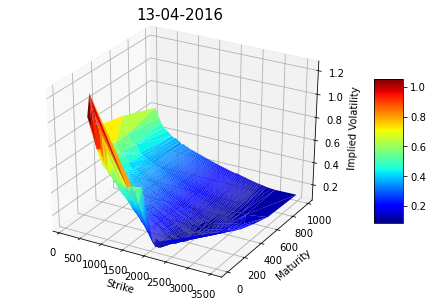

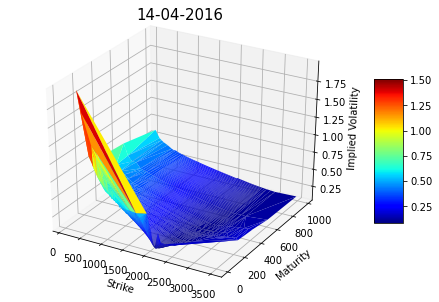

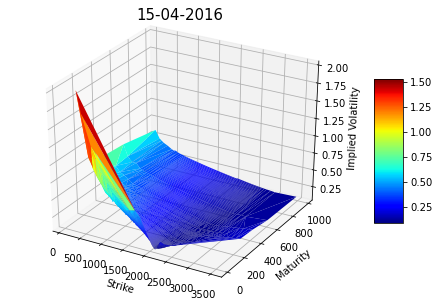

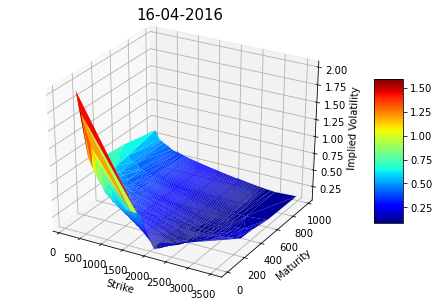

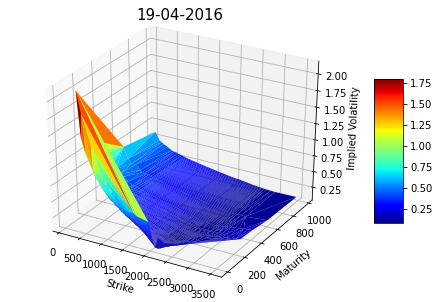

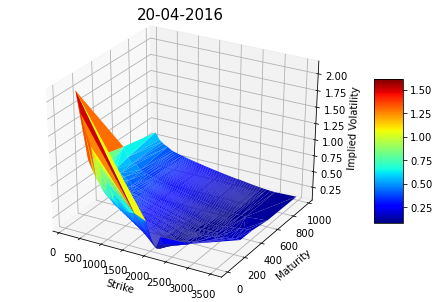

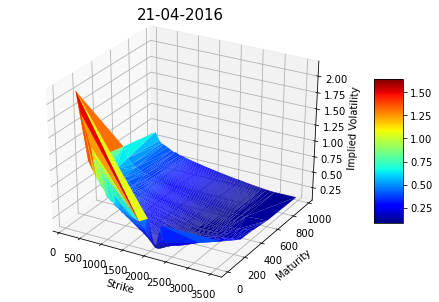

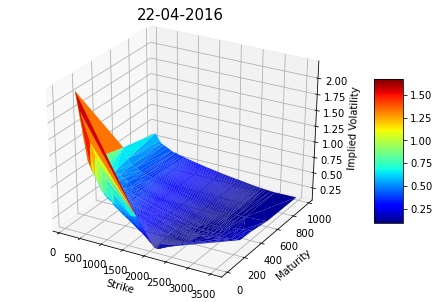

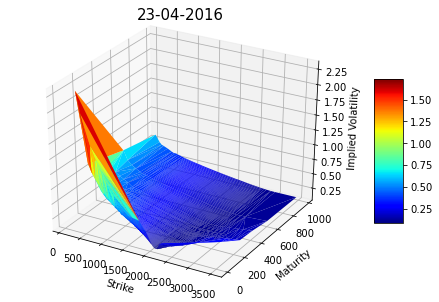

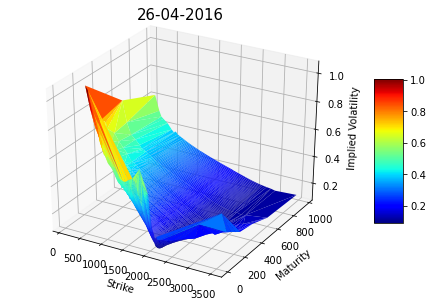

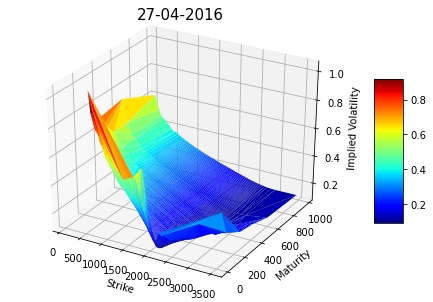

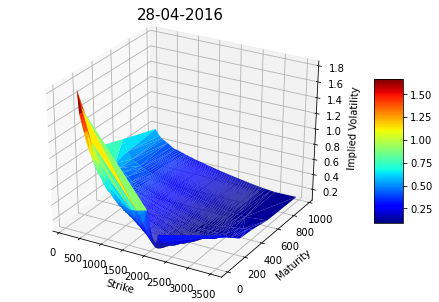

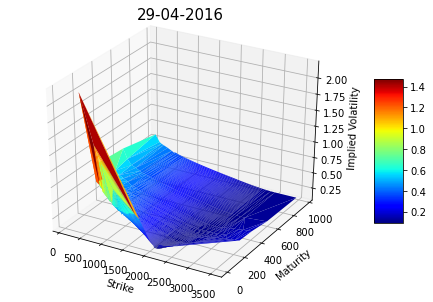

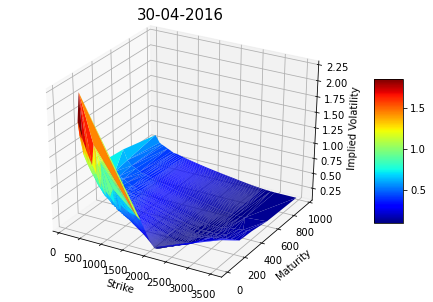

In [9]:
for i in OTM_options['t'].unique():
    df = OTM_options[OTM_options['t']==i]
    
    fig = plt.figure()

    y = df['Maturity']
    x = df['Strike Price']
    z = df['BS IV']
    
    ax = Axes3D(fig)
    surf = ax.plot_trisurf(x, y, z, cmap=cm.jet, linewidth=0.1)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    
    ax.set_xlabel('Strike')
    ax.set_ylabel('Maturity')
    ax.set_zlabel('Implied Volatility')
    
    ax.set_title(str(i)[0:6]+'2016', fontsize=15, loc='center',pad=10)
    plt.show()

#### Estimated the IV for each day and for each maturity in that day

In [10]:
IV=[]
today=[]
maturity=[]

for i in OTM_options['t'].unique():
    for j in OTM_options[OTM_options['t']==i]['Maturity'].unique():
        df = OTM_options[(OTM_options['t']==i) & (OTM_options['Maturity']==j)]
        Kvector = np.array(df['Strike Price'])
        IVvector = np.array(df['BS IV'])
        S0 = np.array(df['Stock Price'])[0]
        T = j
        r = np.array(df['interest rate'])[0]
        
        IV.append(RiskNeutralVolatilitySkewKurt_JVKR(Kvector, IVvector, S0, T, r))
        today.append(i)
        maturity.append(j)

<ipython-input-8-e93c8518e62b>:35: RuntimeWarning: invalid value encountered in power
  skew=( np.exp(r*T)*W - 3*mu*np.exp(r*T)*V + 2*np.power(mu,3)) / np.power(np.exp(r*T)*V - np.power(mu,2),3/2),
<ipython-input-8-e93c8518e62b>:35: RuntimeWarning: invalid value encountered in power
  skew=( np.exp(r*T)*W - 3*mu*np.exp(r*T)*V + 2*np.power(mu,3)) / np.power(np.exp(r*T)*V - np.power(mu,2),3/2),
<ipython-input-8-e93c8518e62b>:35: RuntimeWarning: invalid value encountered in power
  skew=( np.exp(r*T)*W - 3*mu*np.exp(r*T)*V + 2*np.power(mu,3)) / np.power(np.exp(r*T)*V - np.power(mu,2),3/2),
<ipython-input-8-e93c8518e62b>:35: RuntimeWarning: invalid value encountered in power
  skew=( np.exp(r*T)*W - 3*mu*np.exp(r*T)*V + 2*np.power(mu,3)) / np.power(np.exp(r*T)*V - np.power(mu,2),3/2),
<ipython-input-8-e93c8518e62b>:35: RuntimeWarning: invalid value encountered in power
  skew=( np.exp(r*T)*W - 3*mu*np.exp(r*T)*V + 2*np.power(mu,3)) / np.power(np.exp(r*T)*V - np.power(mu,2),3/2),
<ipython-i

In [11]:
interpolated = pd.DataFrame()
interpolated['date']= today
interpolated['maturity']= maturity
interpolated['vix']= IV

#### Interpolated the IV for a maturity of 30 days

In [12]:
int_vix=[]

for i in interpolated['date'].unique():
    S0 = np.array(OTM_options[OTM_options['t']==i]['Stock Price'])[0]
    r = np.array(OTM_options[OTM_options['t']==i]['interest rate'])[0]
    T = 30
    
    y = np.array(interpolated[interpolated['date']==i]['vix'])
    x = np.array(interpolated[interpolated['date']==i]['maturity'])

    pol = np.polyfit(x,y,len(x)-1)
    yy = np.polyval(pol,30)

    int_vix.append(yy)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: 

Another approach is to first interpolate for the Implied Volatility at 30 days for each strike at each day, given that the Implied Volatility surface is assumed to be smooth. Once we find the Implied Volatility values at 30 days, we then run the function to obtain the value of the VIX at 30 days for each date. 

In [13]:
Kvector = []
IVvector = []
vix_IV = []

for i in OTM_options['t'].unique():
    S0 = np.array(OTM_options[OTM_options['t']==i]['Stock Price'])[0]
    r = np.array(OTM_options[OTM_options['t']==i]['interest rate'])[0]
    T = 30
    for j in OTM_options[OTM_options['t']==i]['Strike Price'].unique():
        y = np.array(OTM_options[(OTM_options['t']==i) & (OTM_options['Strike Price']==j)]['BS IV'])
        x = np.array(OTM_options[(OTM_options['t']==i) & (OTM_options['Strike Price']==j)]['Maturity'])
        
        pol = np.polyfit(x,y,len(x)-1)
        yy = np.polyval(pol,30)
        
        Kvector.append(j)
        IVvector.append(yy)
        
    vix_IV.append(RiskNeutralVolatilitySkewKurt_JVKR(Kvector, IVvector, S0, T, r))
    
    Kvector = []
    IVvector = []        

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: RankWarning: 

#### Plotted the real VIX vs our estimation for the selected period

In [34]:
start_date=dt.datetime(2016,1,1)
end_date=dt.datetime(2016, 4, 30)

Vola_2016=web.DataReader('^VIX','yahoo',start_date,end_date)['Adj Close'].to_frame()

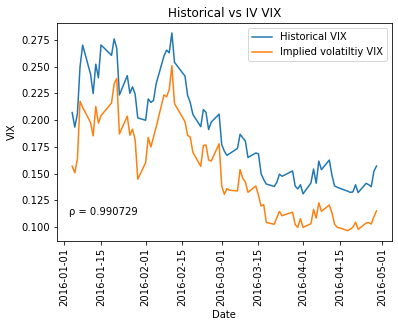

In [35]:
corr = str(np.corrcoef(Vola_2016['Adj Close'],vix_IV)[1][0])[0:8]

x_Vola= Vola_2016.index
y_Vola= Vola_2016['Adj Close']/100
y_vix = vix_IV
plt.plot(x_Vola,y_Vola, label='Historical VIX')
plt.plot(x_Vola,y_vix, label = 'Implied volatiltiy VIX')
plt.title('Historical vs IV VIX')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('VIX')
plt.text(0.3, 0.4,'ρ = '+corr,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)
plt.legend()
plt.show()

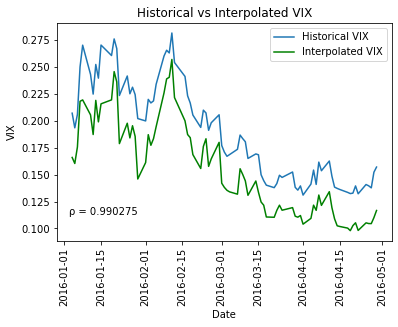

In [36]:
corr = str(np.corrcoef(Vola_2016['Adj Close'],int_vix)[1][0])[0:8]

x_Vola= Vola_2016.index
y_Vola= Vola_2016['Adj Close']/100
y_vix = int_vix
plt.plot(x_Vola,y_Vola, label='Historical VIX')
plt.plot(x_Vola,y_vix, label = 'Interpolated VIX', color='g')
plt.title('Historical vs Interpolated VIX')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('VIX')
plt.text(0.3, 0.4,'ρ = '+corr,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)
plt.legend()
plt.show()

#### Analyzed the correlation of the 2 different interpolation methods

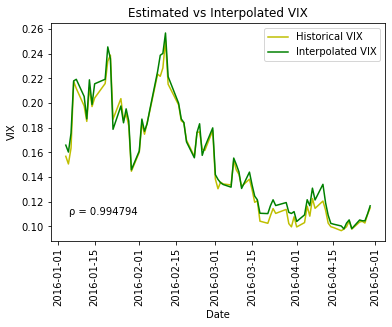

In [37]:
corr = str(np.corrcoef(vix_IV,int_vix)[1][0])[0:8]

x_Vola= Vola_2016.index
y_Vola= vix_IV
y_vix = int_vix
plt.plot(x_Vola,y_Vola, label='Historical VIX', color ='y')
plt.plot(x_Vola,y_vix, label = 'Interpolated VIX', color='g')
plt.title('Estimated vs Interpolated VIX')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('VIX')
plt.text(0.3, 0.4,'ρ = '+corr,
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)
plt.legend()
plt.show()